# <font color='blue'>Formação Cientista de Dados
# <font color='red'>Curso: Machine Learning
    Projeto com Feedback 7
Medicina Personalizada - Redefinindo o
Tratamento de Câncer
    </font>
## Aluno: Eduardo Frigini de Jesus
#### 8/24/19

In [ ]:
# Instalar os pacotes caso nao estejam instalados
#!pip install gensim
#!pip install scikit-plot
#!pip install xgboost
# !pip install TensorFlow

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import tensorflow as tf

In [8]:
# tf.test.is_built_with_cuda()
# tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [10]:
import gensim

In [11]:
import scikitplot.plotters as skplt

In [12]:
import nltk
import os
import seaborn as sns


In [13]:
from xgboost import XGBClassifier

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils import multi_gpu_model

Using TensorFlow backend.


## Carregando training_text e training_variants

In [15]:
df_train_txt = pd.read_csv('training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_train_var = pd.read_csv('training_variants')
df_test_txt = pd.read_csv('test_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_test_var = pd.read_csv('test_variants')

### Juntando os datasets

In [16]:
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [17]:
df_test = pd.merge(df_test_var, df_test_txt, how='left', on='ID')
df_test.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


## Executando as estatísticas preliminares nos dados carregados

In [18]:
df_train.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [19]:
df_test.describe(include='all')

,ID,Gene,Variation,Text
count,5668.000000,5668,5668,5667
unique,NaN,1397,5628,5610
top,NaN,F8,Truncating Mutations,Mutations in BRCA1 and BRCA2 account for the m...
freq,NaN,134,18,6
mean,2833.500000,NaN,NaN,NaN
std,1636.354994,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,1416.750000,NaN,NaN,NaN
50%,2833.500000,NaN,NaN,NaN
75%,4250.250000,NaN,NaN,NaN


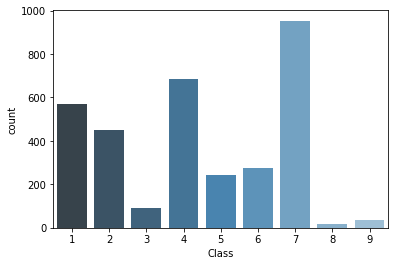

In [20]:
# df_train['Class'].value_counts().plot(kind="bar", rot=0)

sns.countplot(x="Class", data=df_train, palette="Blues_d")


#### As classes estao muito desbalanceadas

#### A principal tarefa aqui é prever a classe da mutação dada pelo texto da literatura. A abordagem será então aplicar algumas técnicas comuns de PNL para transformar o texto livre em recursos para um classificador ML e ver quais funcionam melhor.
#### Definir uma função auxiliar para avaliar a eficácia do texto livre transformado. Devo usar uma regressão logística simples com validação cruzada estratificada de três vezes para avaliação rápida.


In [21]:
def evaluate_features(X, y, clf=None):
    if clf is None:
        clf = LogisticRegression()  
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

## Iniciando com uma baseline simples. Bag of words

In [17]:
count_vectorizer = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize, 
                                   preprocessor=None, stop_words='english', max_features=None)    

In [18]:
len(df_train.Text)

3321

In [19]:
# Saco de palavras # demora para rodar, 5 minutos ou mais
bag_of_words = count_vectorizer.fit_transform(df_train.Text.values.astype('U'))

In [20]:
len(count_vectorizer.get_feature_names())

279980

#### 279980 palavras unicas no corpus

## TFIDF. 
### O valor tf–idf, é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico. Ela é frequentemente utilizada como fator de ponderação na recuperação de informações e na mineração de dados.

In [22]:
count_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
                    preprocessor=None, stop_words='english', max_features=None)  

In [23]:
# demora para rodar

In [23]:
tfidf = count_vectorizer.fit_transform(df_train.Text.values.astype('U'))

In [24]:
len(count_vectorizer.get_feature_names())

279980

In [25]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
C:\Users\edufr\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.7026576714985961
Accuracy: 0.37277928334838906


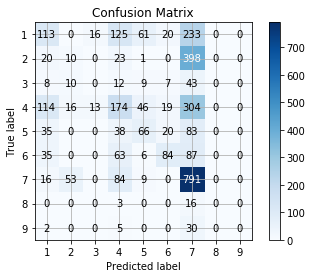

In [26]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel())

## Desta vez, vamos tentar o popular word2vec para obter recursos

### Definindo a função auxiliar get_word2vec e a classe auxiliar MySentences para o treinamento word2vec no corpus de textos. (ou carregando se já treinado e salvo no disco)

In [24]:
""" A MySentences é um gerador para produzir uma lista de sentenças tokenized
    Obtém uma lista de matrizes numpy contendo documentos.
    Args: matrizes: lista de matrizes, onde cada elemento da matriz contém um documento. """

class MySentences(object):
    def __init__(self, *arrays):
        self.arrays = arrays
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)


In [25]:
"""Retorna o word2vec treinado
     Args: sentenças: iterador para sentenças
     location (str): Caminho para salvar / carregar word2vec """
                    
def get_word2vec(sentences, location):
    if os.path.exists(location):
        print('Encontrado {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    print('{} não encontrado. modelo de treinamento'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Modelo de treinamento feito. Salvando no disco')
    model.save(location)
    return model

### Treinando o modelo word2vec. Como o treinamento word2vec não é supervisionado, você pode usar os conjuntos de dados de treinamento e de teste.

Se o treinamento já foi feito, a função apenas carregará o word2vec para o disco, para que você não precise retreinare se estiver executando novamente o notebook

In [26]:
w2vec = get_word2vec(MySentences(df_train.Text.values[:10], ), 'w2vmodel')

Encontrado w2vmodel


In [29]:
w2vec.

array([  42050619,   80428289,  116439826, ..., 2146885054, 2147184350,
       2147483647], dtype=uint32)

### Agora que temos o nosso modelo word2vec, como podemos usá-lo para transformar cada documento em um vetor de recursos? Para converter um documento de várias palavras em um único vetor usando a funcao word2vec, pegamos a word2vec de todas as palavras do documento e, em seguida, obtemos sua média.

### Definiremos um transformador (com interface sklearn) para converter um documento em seu vetor correspondente

In [30]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

# se um texto estiver vazio, devemos retornar um vetor de zeros
# com a mesma dimensionalidade de todos os outros vetores
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)


In [31]:
# demora, enche a memoria RAM

In [32]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(df_train.Text.values.astype('U'))

## LSTM em Keras para levar em conta a natureza sequencial do texto

* Não faremos nenhuma pesquisa com hiperparâmetros
* Vamos com 15 épocas, e salve o modelo com a melhor perda de validação depois de uma época
* O tamanho máximo da sequência é reduzido a um mínimo de 2000 (o texto mais longo tem 77000+ palavras), para reduzir o tempo de treinamento e evitar a GPU BOOM

Nota: Isso leva cerca de uma hora para ser executado na GPU

In [33]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train.Text.values.astype('U'))

In [34]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_train.Text.values.astype('U'))
X = pad_sequences(X, maxlen=2000)

In [35]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

W0824 15:12:32.509390  6312 deprecation_wrapper.py:119] From C:\Users\edufr\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 15:12:32.684489  6312 deprecation_wrapper.py:119] From C:\Users\edufr\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 15:12:32.742815  6312 deprecation_wrapper.py:119] From C:\Users\edufr\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 15:12:33.017574  6312 deprecation_wrapper.py:119] From C:\Users\edufr\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0824 15:12:33.044554  6312 deprecation.py:506

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1773      
Total params: 512,573
Trainable params: 512,573
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
Y = pd.get_dummies(df_train['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2656, 2000) (2656, 9)
(665, 2000) (665, 9)


In [37]:
# Demorou mais de 1 hora para rodar na GPU

In [38]:
batch_size = 256
model.fit(X_train, Y_train, epochs=10, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

W0824 15:12:41.577076  6312 deprecation.py:323] From C:\Users\edufr\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2124 samples, validate on 532 samples
Epoch 1/10
2124/2124 [==============================] - 62s 29ms/step - loss: 2.1533 - categorical_crossentropy: 2.1533 - val_loss: 1.9581 - val_categorical_crossentropy: 1.9581

Epoch 00001: val_loss improved from inf to 1.95808, saving model to keras_model
Epoch 2/10
2124/2124 [==============================] - 56s 27ms/step - loss: 1.9127 - categorical_crossentropy: 1.9127 - val_loss: 1.8610 - val_categorical_crossentropy: 1.8610

Epoch 00002: val_loss improved from 1.95808 to 1.86101, saving model to keras_model
Epoch 3/10
2124/2124 [==============================] - 57s 27ms/step - loss: 1.8260 - categorical_crossentropy: 1.8260 - val_loss: 1.8528 - val_categorical_crossentropy: 1.8528

Epoch 00003: val_loss improved from 1.86101 to 1.85282, saving model to keras_model
Epoch 4/10
2124/2124 [==============================] - 62s 29ms/step - loss: 1.7876 - categorical_crossentropy: 1.7876 - val_loss: 1.7963 - val_categorical_crossentrop

In [39]:
model = load_model('keras_model')

In [40]:
probas = model.predict(X_test)

Log loss: 1.4333678396460705
Accuracy: 0.5067669172932331


C:\Users\edufr\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


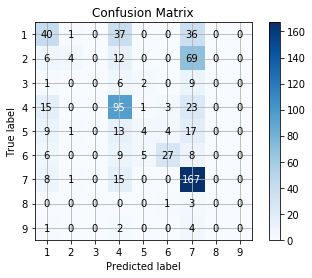

In [41]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)
